In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tables
import glob
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from astropy.table import Table
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.cm import get_cmap
%matplotlib notebook

First we must grab and generate iPTF 16abc light curves, in absolute magnitude

In [2]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict(), "LCO-1m/Sinistro": dict(), "Swift/UVOT": dict(), "SPM-1.5m/RATIR": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["B", "V", "g", "r", "i"]:
    lc["LCO-1m/Sinistro"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name, mag_name in zip(["B", "V"], ["B_ab", "V_ab"]):
    lc["LCO-1m/Sinistro"][mag_name] =\
        np.array([(row["time"], -2.5*np.log10(row["flux"]/3631), 2.5/np.log(10)*row["flux_err"]/row["flux"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

for filter_name in ["UVW2", "UVM2", "UVW1", "U", "B", "V"]:
    lc["Swift/UVOT"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'Swift') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

for filter_name in ["r", "i", "Z", "Y", "J", "H"]:
    lc["SPM-1.5m/RATIR"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'SPM-1.5m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])    
        
h5file.close()

In [3]:
# properties iPTF16abc
z = 0.0234
mu = 34.89
mu_unc = 0.10
t = 0.15  # days. First detection of iPTF16abc
mag = 21.4  # mag. First mag of iPTF16abc
local_EBV = 0.05
galactic_EBV = 0.0279
T_MAX = 57499.537694
T_fl = 57481.2

A_g = 0.33 # assuming E(B-V)_SFD = 0.0779/0.78
A_r = 0.23
A_B = 0.36
A_V = 0.27
A_U = 0.43

# properties for making plots
colors = {"UVW2": "#D0E1F9",
          "UVM2": "#008DCB",
          "UVW1": "Cyan",
          "U": "DarkBlue",
          "B": "Blue",
          "V": "#68A225", 
          "g": "LightSeaGreen",
          "R": "Crimson", 
          "r": "Crimson",
          "i": "#FFDB5C",
          "Z": "#FE0000",
          "Y": "#882426",
          "J": "#C9A66B",
          "H": "#C5001A"}

markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s", 
           "SPM-1.5m": "p"}
offsets = {"UVW2": -5,
           "UVM2": -5,
           "UVW1": -1,
           "U": 2,
           "B": -1.5,
           "V": 1,
           "g": 0,
           "R": 2,
           "r": 2,
           "i": 3,
           "Z": 4,
           "Y": 5,
           "J": 6,
           "H": 7}


AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#5F9683", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#FF0038", # fig
             'B-V': "#727077", # slate grey
#              'B-V': "#012161", # royal blue
             'g-r': "#6599FF", # light blue #F77604", # caviar
             'r-i': "#FF0038",  # ripe tomato
             'i-Z': "#AF4425", # cayene
             'Z-Y': "#662225", # red onion 
             'J-H': "#C9A66B" # cinnamon
             } 



AAMoffsets = {'UVW2-V': 1, # midnight blue
              'UVW1-V': 1, # fig or #50312F eggplant
              'U-V': 2, # blueberry
              'B-V': 1, # yellow pepper
              'g-r': 0, # carrot
              'r-i': -1,  # tomato
              'i-Z': -3, # cinnamon
              'Z-Y': -4, # red onion 
              'J-H': -6 # cayene
             }
g_filt_dict = {"P48/CFH12K": "g", "P60/SEDm": "g'", "LCO-1m/Sinistro": "g'"}

In [4]:
def lc_color(t_blue, m_blue, m_blue_unc, t_red, m_red, m_red_unc, delta_t_merge = 1/24):
    """Return the (merged) color curve for two filters 
    
    Parameters
    ----------
    t_blue : array-like 
        Time array for blue filter measurements
        
    m_blue : array-like, shape = t_blue.shape
        mag array for the blue filter measurements
        
    m_blue_unc : array-like, shape = t_blue.shape
        mag uncertainties array for the blue filter measurements
    
    t_red : array-like
        Time array for red filter measurements
        
    m_red : array-like, shape = t_red.shape
        mag array for the red filter measurements
        
    m_red_unc : array-like, shape = t_red.shape
        mag uncertainties array for the red filter measurements

    delta_t_merge : float, optional (default = 1/24)
    
    Returns
    -------
    t_color : array-like
        mean time of joined red and blue filter obs 
    
    m_color : array-like
        mag of joined red and blue filter obs
    
    m_color_unc : array-like
        mag uncertainty for joined red and blue filter obs
    """

    if len(t_blue) != len(m_blue) or len(t_blue) != len(m_blue_unc):
        raise ValueError('Length of t_blue, m_blue, and m_blue_unc do not match')

    if len(t_red) != len(m_red) or len(t_red) != len(m_red_unc):
        raise ValueError('Length of t_red, m_red, and m_red_unc do not match')

    t_red = np.ma.array(t_red, mask = np.zeros(t_red.shape))
    m_red = np.ma.array(m_red, mask = np.zeros(m_red.shape))
    m_red_unc = np.ma.array(m_red_unc, mask = np.zeros(m_red_unc.shape))
    
    t_color = np.empty(0)
    m_color = np.empty(0)
    m_color_unc = np.empty(0)
    delta_t_merge = 1/24.
    
    for tb, mb, mbu in zip(t_blue, m_blue, m_blue_unc):
        if np.min(np.abs(t_red - tb)) < delta_t_merge:
            match_idx = np.argmin(np.abs(t_red - tb))
            t_color = np.append(t_color, (tb + t_red[match_idx]) / 2)
            m_color = np.append(m_color, mb - m_red[match_idx] )

            m_color_unc = np.append(m_color_unc, 
                                    np.hypot(mbu, m_red_unc[match_idx]))
            t_red.mask[match_idx] = True
    
    return t_color, m_color, m_color_unc

In [5]:
t_bv, m_bv, m_bv_unc = lc_color(lc['LCO-1m/Sinistro']['B_ab']['time'], 
                                lc['LCO-1m/Sinistro']['B_ab']['mag'], 
                                lc['LCO-1m/Sinistro']['B_ab']['mag_err'],
                                lc['LCO-1m/Sinistro']['V_ab']['time'], 
                                lc['LCO-1m/Sinistro']['V_ab']['mag'], 
                                lc['LCO-1m/Sinistro']['V_ab']['mag_err'])

t_gr_lco, m_gr_lco, m_gr_lco_unc = lc_color(lc['LCO-1m/Sinistro']['g']['time'], 
                                lc['LCO-1m/Sinistro']['g']['mag'], 
                                lc['LCO-1m/Sinistro']['g']['mag_err'],
                                lc['LCO-1m/Sinistro']['r']['time'], 
                                lc['LCO-1m/Sinistro']['r']['mag'], 
                                lc['LCO-1m/Sinistro']['r']['mag_err'])

t_gr_p60, m_gr_p60, m_gr_p60_unc = lc_color(lc['P60/SEDm']['g']['time'], 
                                lc['P60/SEDm']['g']['mag'], 
                                lc['P60/SEDm']['g']['mag_err'],
                                lc['P60/SEDm']['r']['time'], 
                                lc['P60/SEDm']['r']['mag'], 
                                lc['P60/SEDm']['r']['mag_err'])

### Read in the light curves from Dessart+14

In [6]:
dessart_models = glob.glob("*lc.h5")

<IPython.core.display.Javascript object>


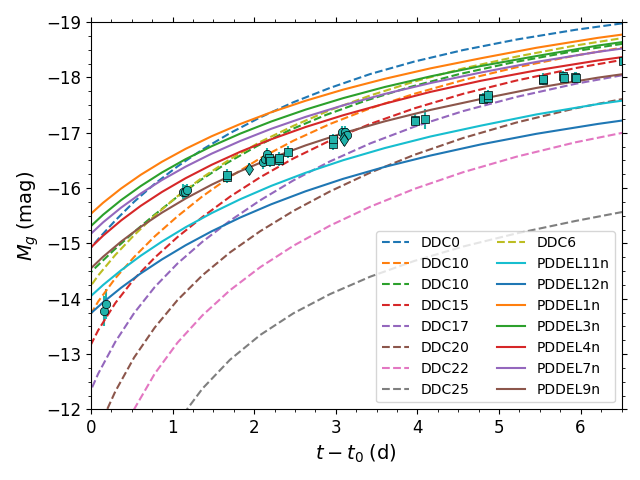

In [136]:
t_offset = 2

fig, ax = plt.subplots()
for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    ax.errorbar( (lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
              lc[tel_inst]['g']['mag'] - mu - A_g, 
              np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
              c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
              mec = 'k', mew = 0.5, ms = 6) #,
#               label="{:s} {:s}".format(tel_inst, g_filt_dict[tel_inst]))

for dessart_model in dessart_models:
    lc_df = pd.read_hdf(dessart_model)
    model_name = dessart_model.split("_")[0]
    if model_name[0:3] == "DDC":
        linestyle = "--"
    else:
        linestyle = "-"
    ax.plot(lc_df['time']-t_offset,lc_df['gP48'], ls = linestyle, 
            label = model_name)
ax.set_xlim(0, 6.5)
ax.set_ylim(-12,-19)
ax.legend(ncol = 2)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_ylabel(r"$M_{g} \; (\mathrm{mag})$", fontsize = 14)
ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)

ax.tick_params(axis='both', which='both', top=True, right=True, 
               labelsize=12)
fig.tight_layout()


The general properties to be inferred from the Dessart models are as follows:
  - models with low M_Ni (< 0.7; DDC10, 15, 17, 20, 22, 25) or (< 0.6; PDDEL4n, 7n, 9n, 11n) do not rise fast enough
  - all models require an offset of >~1 day to match first observation
  - DDC0 is only DDC model with reasonable color evolution
  - extra mixing enhances the luminosity at early times DDC10_M4 (but for the only model with mixing does not show a good match)

**upshot**: B-V only matches for large offsets (> 2 d) but that messes up early g-band observations

<IPython.core.display.Javascript object>


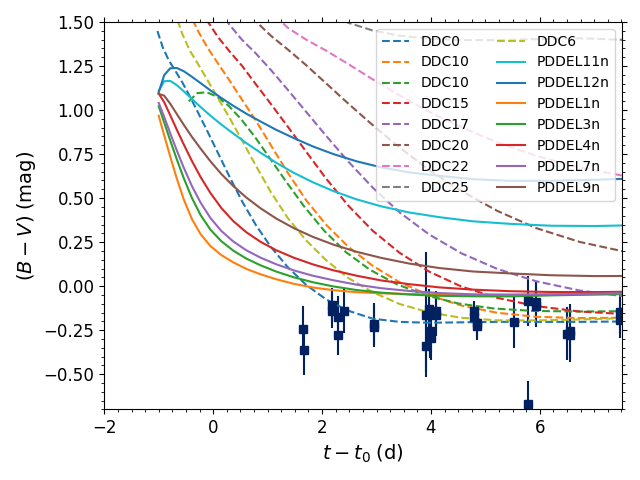

In [12]:
fig, ax = plt.subplots()

ax.errorbar((t_bv - T_fl)/(1+z), m_bv - (A_B - A_V), m_bv_unc, 
            fmt = markers["LCO-1m"], color = AAMcolors["B-V"])

BV_vega2ab = -2.5*np.log10(4063/3631) + 2.5*np.log10(3636/3631)

for dessart_model in dessart_models:
    lc_df = pd.read_hdf(dessart_model)
    model_name = dessart_model.split("_")[0]
    if model_name[0:3] == "DDC":
        linestyle = "--"
    else:
        linestyle = "-"
    ax.plot(lc_df['time'] - t_offset, lc_df['B'] - lc_df['V'], 
            ls = linestyle, label = model_name)
ax.legend()
ax.set_ylim(-0.7, 1.5)
ax.set_xlim(0 - t_offset, 9.5 - t_offset)

ax.legend(ncol = 2)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_ylabel(r"$(B - V) \; (\mathrm{mag})$", fontsize = 14)
ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)

ax.tick_params(axis='both', which='both', top=True, right=True, 
               labelsize=12)

fig.tight_layout()

### Read in the light curves from Noebauer+17

In [16]:
noebauer_models = glob.glob("/Users/adamamiller/astronomy/SN_Ia_models/Noebauer17/LCs/*B.dat")

<IPython.core.display.Javascript object>


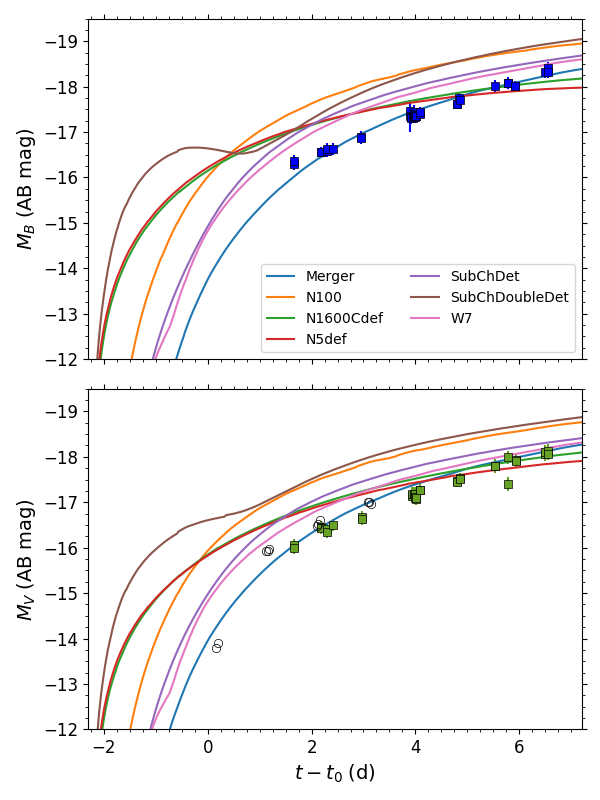

In [121]:
t_offset = 2.3

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (6,8))
ax1.errorbar( (lc["LCO-1m/Sinistro"]['B_ab']['time'] - T_fl)/(1+z), 
              lc["LCO-1m/Sinistro"]['B_ab']['mag'] - mu - A_B, 
              np.hypot(lc["LCO-1m/Sinistro"]['B_ab']['mag_err'], 0.1), 
              c = colors['B'], fmt = markers["LCO-1m"], 
              mec = 'k', mew = 0.5, ms = 6) #,

for noebauer_model in noebauer_models:
    model_t, model_b = np.loadtxt(noebauer_model, usecols=[0,1], unpack=True)    
    ax1.plot(model_t - t_offset, model_b, label = noebauer_model.split("/")[-1].split("_")[0])

ax2.errorbar( (lc["LCO-1m/Sinistro"]['V_ab']['time'] - T_fl)/(1+z), 
              lc["LCO-1m/Sinistro"]['V_ab']['mag'] - mu - A_V, 
              np.hypot(lc["LCO-1m/Sinistro"]['V_ab']['mag_err'], 0.1), 
              c = colors['V'], fmt = markers["LCO-1m"], 
              mec = 'k', mew = 0.5, ms = 6) #,

ax2.errorbar( (lc["P48/CFH12K"]['g']['time'] - T_fl)/(1+z), 
              lc["P48/CFH12K"]['g']['mag'] - mu - A_g, 
              np.hypot(lc["P48/CFH12K"]['g']['mag_err'], 0.1), 
              c = "none", fmt = markers["P48"], 
              mec = 'k', mew = 0.5, ms = 6)

for noebauer_model in noebauer_models:
    model_t, model_b = np.loadtxt(noebauer_model.replace("_B.","_V."), 
                                  usecols=[0,1], unpack=True)    
    ax2.plot(model_t - t_offset, model_b, 
             label = noebauer_model.split("/")[-1].split("_")[0])

ax1.set_xlim(0-t_offset, 9.5-t_offset)
ax1.set_ylim(-12,-19.5)
ax1.legend(ncol = 2)
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))

ax1.set_ylabel(r"$M_{B} \; (\mathrm{AB\;mag})$", fontsize = 14)
ax2.set_ylabel(r"$M_{V} \; (\mathrm{AB\;mag})$", fontsize = 14)
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)

for axis in [ax1, ax2]:
    axis.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=12)
fig.tight_layout()

Based on the B and V evolution, the following conclusions can be drawn:
  - The SubChDoubleDet rises too fast 1-2 d after explosion (also colors, below, are a poor match)
  - N100 is difficult to reconcile with t < 3 and t > 3 evolution (offset = 0.7 provides decent color match, but too bright at t > 3 d)
  - N1600 & N5 both match early decently well, but t > 3 is too faint (colors are blue, but evolving to red)
  - SubChDet is very similar to W7, but does not match the models as well
  - W7 looks pretty good with 1.4 d offset
  - Merger provides a decent match with 2.25 d offset, color seems a bit too red however

<IPython.core.display.Javascript object>


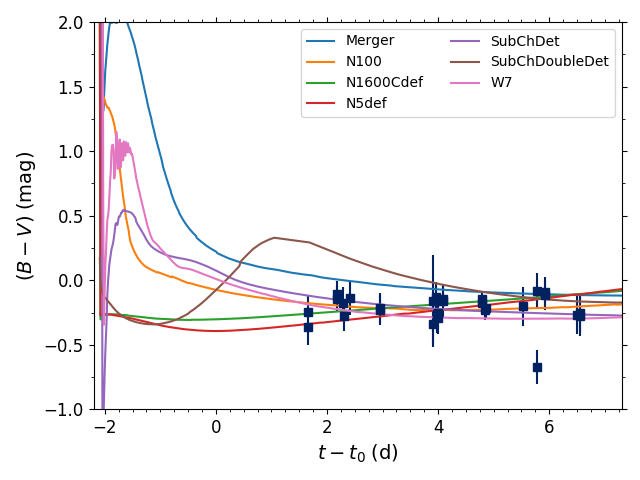

In [120]:
fig, ax = plt.subplots()

ax.errorbar((t_bv - T_fl)/(1+z), m_bv - (A_B - A_V), m_bv_unc, 
            fmt = markers["LCO-1m"], color = AAMcolors["B-V"])

for noebauer_model in noebauer_models:
    model_t, model_b = np.loadtxt(noebauer_model, usecols=[0,1], unpack=True)
    model_t_v, model_v = np.loadtxt(noebauer_model.replace("_B.","_V."), 
                                    usecols=[0,1], unpack=True)
    if sum(model_t_v - model_t) != 0:
        print("The time stamps are not identical for these files")
    
    ax.plot(model_t - t_offset, model_b - model_v, 
            label = noebauer_model.split("/")[-1].split("_")[0])
ax.legend()
ax.set_ylim(-1, 2)
ax.set_xlim(0 - t_offset, 9.5 - t_offset)

ax.legend(ncol = 2)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_ylabel(r"$(B - V) \; (\mathrm{mag})$", fontsize = 14)
ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)

ax.tick_params(axis='both', which='both', top=True, right=True, 
               labelsize=12)

fig.tight_layout()

### Publication plots

At this stage, it is clear that the publication should feature 3 different plots similar to the one that was previously made for the Piro et al paper. Each of these plots should then include the models that seem to best replicate the observations, and explain the sorts of offsets needed to get a good match.

<IPython.core.display.Javascript object>


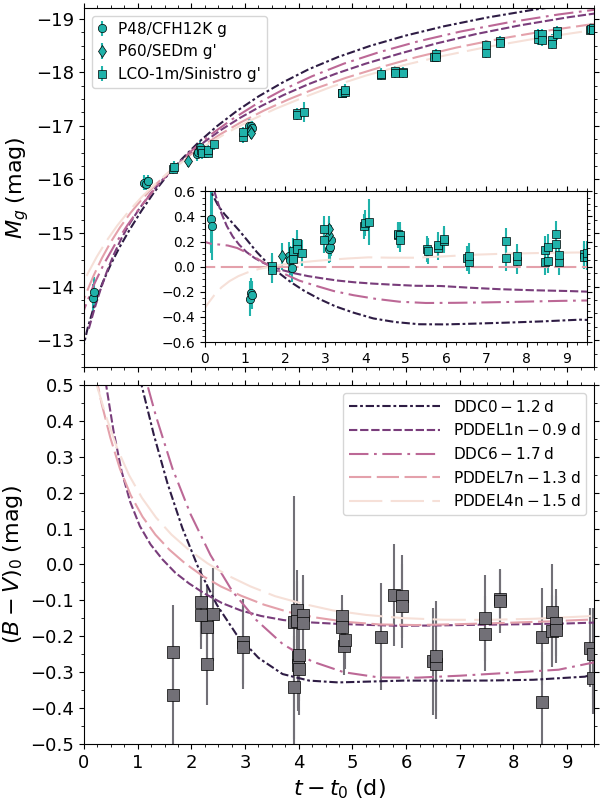

In [14]:
# Dessart plot

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (6,8))

ax_ins = inset_axes(ax1, width="75%", height="42%", 
                    bbox_to_anchor=(0.0,0.05, 1, 1), bbox_transform=ax1.transAxes, 
                    loc=4)

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    ax1.errorbar( (lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
              lc[tel_inst]['g']['mag'] - mu - A_g, 
              np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
              c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
              mec = 'k', mew = 0.5, ms = 6,
              label="{:s} {:s}".format(tel_inst, g_filt_dict[tel_inst]))
leg = ax1.legend(loc = 2, fancybox=True, 
                 handlelength=0.5, fontsize=11) # set legend here to exclude line labels

ax2.errorbar((t_bv - T_fl)/(1+z), m_bv - (A_B - A_V), m_bv_unc, 
             mec = 'k', mew = 0.5, ms = 8,
             fmt = markers["LCO-1m"], color = AAMcolors["B-V"])

# cmap = sns.light_palette("#FF0038", as_cmap=True)
cmap = sns.cubehelix_palette(8, light=0.15, dark=0.9, hue=1, as_cmap=True)
# cmap = sns.cubehelix_palette(start=1.3, rot = -0.3, as_cmap=True)
# cmap = get_cmap("viridis")

n_models = 5
dash_list = [[3, 1,1,1], [3, 1], [7, 2,1,2], [8, 2], [12, 3]]
cmap_list = cmap(np.linspace(0,1,n_models))
tgrid = np.linspace(0, 4, 401)
resid_df = pd.read_hdf('PDDEL7n_lc.h5')
resid_offset = tgrid[np.argmin(np.abs(np.interp(tgrid, resid_df['time'], resid_df['gP48']) + 16.2))] - 1.66
for dessart_model, line_color, linestyle in zip(['DDC0_0p5d_lc.h5', 'PDDEL1n_lc.h5', 
                                                 'DDC6_0p5d_lc.h5',
                                                 'PDDEL7n_lc.h5','PDDEL4n_lc.h5'],
                                                cmap_list, dash_list):
    lc_df = pd.read_hdf(dessart_model)
    model_name = dessart_model.split("_")[0]
    
    interp_model = np.interp(tgrid, lc_df['time'], lc_df['gP48'])
    t_offset = tgrid[np.argmin(np.abs(interp_model + 16.2))] - 1.66
    ax1.plot(lc_df['time'] - t_offset, lc_df['gP48'], 
             dashes = linestyle, color = line_color,
             label = r"$\mathrm{{{:s}}} - {{{:.1f}}}$".format(model_name, t_offset))
    interp_resids = np.interp(lc_df['time'] - t_offset, resid_df['time'] - resid_offset, resid_df['gP48'])
    ax_ins.plot(lc_df['time'] - t_offset, lc_df['gP48'] - interp_resids, 
                dashes = linestyle, color = line_color,
                label = r"$\mathrm{{{:s}}} - {{{:.1f}}}$".format(model_name, t_offset))
    ax2.plot(lc_df['time'] - t_offset, lc_df['B'] - lc_df['V'], 
             dashes = linestyle, color = line_color,
             label = r"$\mathrm{{{:s}}} - {{{:.1f}}}\;\mathrm{{d}}$".format(model_name, t_offset))
ax2.legend(loc=1, handlelength=6, fontsize=11)

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    interp_resids = np.interp((lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
                              resid_df['time'] - resid_offset, resid_df['gP48'])
    ax_ins.errorbar( (lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
                  lc[tel_inst]['g']['mag'] - mu - A_g - interp_resids, 
                  np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
                  c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
                  mec = 'k', mew = 0.5, ms = 6)

ax1.set_ylim(-12.5,-19.2)
for axis in [ax1, ax_ins]:
    axis.set_xlim(0, 9.5)
    axis.xaxis.set_minor_locator(MultipleLocator(0.25))
    axis.xaxis.set_major_locator(MultipleLocator(1))

ax2.set_ylim(-0.5,0.5)
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax_ins.set_ylim(-0.6,0.6)
ax_ins.yaxis.set_minor_locator(MultipleLocator(0.05))
ax_ins.yaxis.set_major_locator(MultipleLocator(0.2))
ax_ins.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=10)

ax1.set_ylabel(r"$M_{g} \; (\mathrm{mag})$", fontsize = 16)
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 16)
ax2.set_ylabel(r"$(B - V)_0 \; (\mathrm{mag})$", fontsize = 16)

for axis in [ax1, ax2]:
    axis.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=13)
    
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))

fig.subplots_adjust(left = 0.14,right=0.99,top=0.99,bottom=0.07,hspace=0.05)
# fig.savefig("compare_Dessart.pdf")

<IPython.core.display.Javascript object>


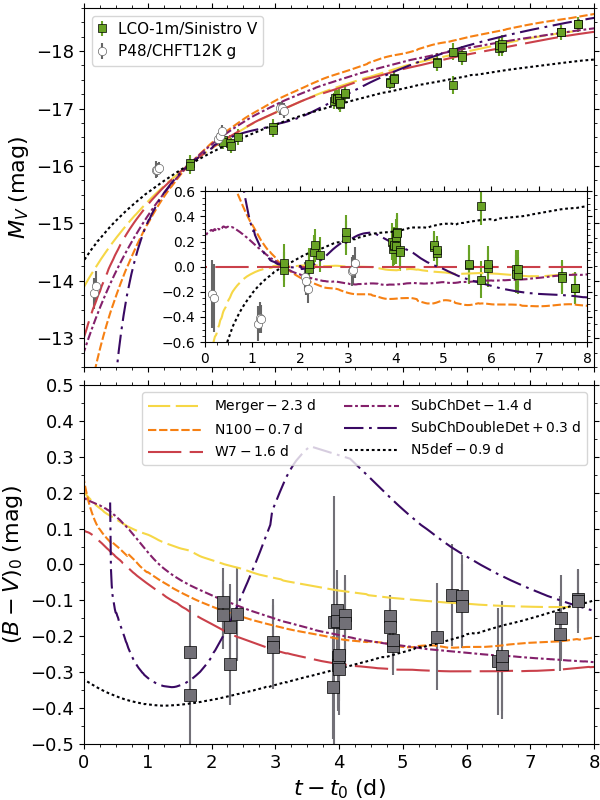

In [18]:
# Noebauer plot

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (6,8))

ax_ins = inset_axes(ax1, width="75%", height="42%", 
                    bbox_to_anchor=(0.0,0.05, 1, 1), bbox_transform=ax1.transAxes, 
                    loc=4)

ax1.errorbar( (lc["LCO-1m/Sinistro"]['V_ab']['time'] - T_fl)/(1+z), 
              lc["LCO-1m/Sinistro"]['V_ab']['mag'] - mu - A_V, 
              np.hypot(lc["LCO-1m/Sinistro"]['V_ab']['mag_err'], 0.1), 
              c = colors['V'], fmt = markers["LCO-1m"], 
              mec = 'k', mew = 0.5, ms = 6,
              label="LCO-1m/Sinistro V")

ax1.errorbar( (lc["P48/CFH12K"]['g']['time'] - T_fl)/(1+z), 
              lc["P48/CFH12K"]['g']['mag'] - mu - A_g, 
              np.hypot(lc["P48/CFH12K"]['g']['mag_err'], 0.1), 
              color = "0.4", mfc = "white", fmt = markers["P48"], 
              mec = "0.4", mew = 0.5, ms = 6,
             label="P48/CHFT12K g")
leg = ax1.legend(loc = 2, fancybox=True,
                handlelength=0.5, fontsize=11) # set legend here to exclude line labels

ax2.errorbar((t_bv - T_fl)/(1+z), m_bv - (A_B - A_V), m_bv_unc, 
             mec = 'k', mew = 0.5, ms = 8,
             fmt = markers["LCO-1m"], color = AAMcolors["B-V"])

cmap = get_cmap("inferno_r")

n_models = 6
dash_list = [[8, 2], [3, 1], [12, 3], [3,1,1,1], [7,2,1,2], [1,1]]
cmap_list = cmap(np.linspace(0.1,1,n_models))
tgrid = np.linspace(0, 6, 601)
resid_t_v, resid_v = np.loadtxt(noebauer_models[6].replace("_B.","_V."), 
                                    usecols=[0,1], unpack=True)
resid_offset = tgrid[np.argmin(np.abs(np.interp(tgrid, resid_t_v, resid_v) + 16.03))] - 1.66
for noebauer_model, line_color, linestyle in zip(np.array(noebauer_models)[[0,1,6,4,5,3]],
                                                 cmap_list, dash_list):
    model_t, model_b = np.loadtxt(noebauer_model, usecols=[0,1], unpack=True)
    model_t_v, model_v = np.loadtxt(noebauer_model.replace("_B.","_V."), 
                                    usecols=[0,1], unpack=True)
    model_name = noebauer_model.split("/")[-1].split("_")[0]

    interp_model = np.interp(tgrid, model_t_v, model_v)
    t_offset = tgrid[np.argmin(np.abs(interp_model + 16.03))] - 1.66
    ax1.plot(model_t - t_offset, model_v,
             color = line_color, dashes = linestyle,
             label = r"$\mathrm{{{:s}}} - {{{:.1f}}}\;\mathrm{{d}}$".format(model_name, t_offset))
    interp_resids = np.interp(model_t_v - t_offset, resid_t_v - resid_offset, resid_v)
    ax_ins.plot(model_t_v - t_offset, model_v - interp_resids, 
                dashes = linestyle, color = line_color,
                label = r"$\mathrm{{{:s}}} - {{{:.1f}}}$".format(model_name, t_offset))

    if t_offset > 0:
        ax2.plot(model_t - t_offset, model_b - model_v, 
             color = line_color, dashes = linestyle,
             label = r"$\mathrm{{{:s}}} - {{{:.1f}}}\;\mathrm{{d}}$".format(model_name, t_offset))
    else:
        ax2.plot(model_t - t_offset, model_b - model_v, 
             color = line_color, dashes = linestyle,
             label = r"$\mathrm{{{:s}}} + {{{:.1f}}}\;\mathrm{{d}}$".format(model_name, -t_offset))

    
interp_resids = np.interp((lc["LCO-1m/Sinistro"]['V_ab']['time'] - T_fl)/(1+z), 
                          resid_t_v - resid_offset, resid_v)
ax_ins.errorbar( (lc["LCO-1m/Sinistro"]['V_ab']['time'] - T_fl)/(1+z), 
              lc["LCO-1m/Sinistro"]['V_ab']['mag'] - mu - A_V - interp_resids, 
              np.hypot(lc["LCO-1m/Sinistro"]['V_ab']['mag_err'], 0.1), 
              c = colors['V'], fmt = markers["LCO-1m"], 
              mec = 'k', mew = 0.5, ms = 6)

interp_resids = np.interp((lc["P48/CFH12K"]['g']['time'] - T_fl)/(1+z), 
                          resid_t_v - resid_offset, resid_v)
ax_ins.errorbar( (lc["P48/CFH12K"]['g']['time'] - T_fl)/(1+z), 
              lc["P48/CFH12K"]['g']['mag'] - mu - A_g - interp_resids, 
              np.hypot(lc["P48/CFH12K"]['g']['mag_err'], 0.1), 
              color = "0.4", mfc = "white", fmt = markers["P48"], 
              mec = "0.4", mew = 0.5, ms = 6) #,

ax2.legend(loc=1, ncol=2,handlelength=4)

ax1.set_ylim(-12.5,-18.75)
for axis in [ax1, ax_ins]:
    axis.set_xlim(0, 8)
    axis.xaxis.set_minor_locator(MultipleLocator(0.25))
    axis.xaxis.set_major_locator(MultipleLocator(1))

ax2.set_ylim(-0.5,0.5)
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax_ins.set_ylim(-0.6,0.6)
ax_ins.yaxis.set_minor_locator(MultipleLocator(0.05))
ax_ins.yaxis.set_major_locator(MultipleLocator(0.2))
ax_ins.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=10)

ax1.set_ylabel(r"$M_{V} \; (\mathrm{mag})$", fontsize = 16)
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 16)
ax2.set_ylabel(r"$(B - V)_0 \; (\mathrm{mag})$", fontsize = 16)

for axis in [ax1, ax2]:
    axis.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=13)

ax1.xaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))

fig.subplots_adjust(left = 0.14,right=0.99,top=0.99,bottom=0.07,hspace=0.05)
# fig.savefig("compare_Noebauer.pdf")

<IPython.core.display.Javascript object>


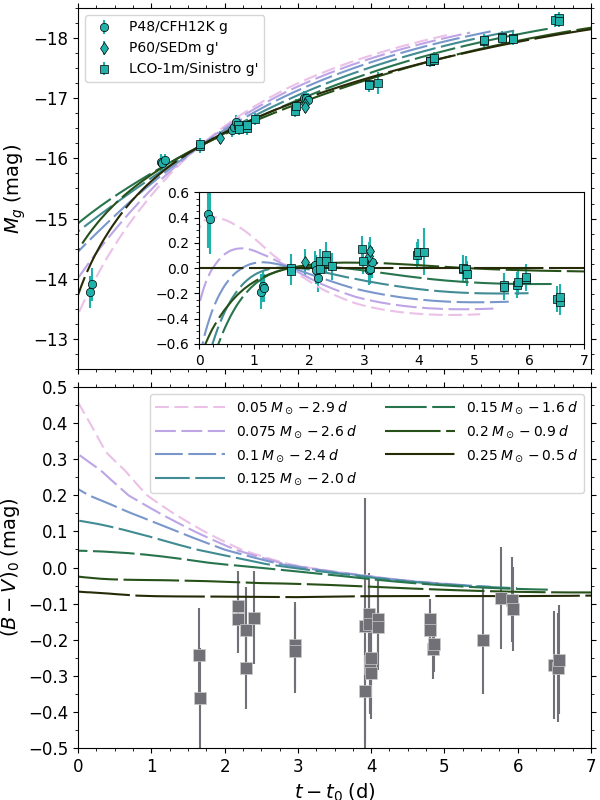

In [274]:
# Piro plot
Piro_col_names = ("Time", "Teff", 
                  "PTF_R", 
                  "u", "g", "r", "i", "z", 
                  "U", "B", "V", "R", "I")

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (6,8))

ax_ins = inset_axes(ax1, width="75%", height="42%", 
                    bbox_to_anchor=(0.0,0.05, 1, 1), bbox_transform=ax1.transAxes, 
                    loc=4)

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    ax1.errorbar( (lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
              lc[tel_inst]['g']['mag'] - mu - A_g, 
              np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
              c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
              mec = 'k', mew = 0.5, ms = 6,
              label="{:s} {:s}".format(tel_inst, g_filt_dict[tel_inst]))
leg = ax1.legend(loc = 2, fancybox=True) # set legend here to exclude line labels

ax2.errorbar((t_bv - T_fl)/(1+z), m_bv - (A_B - A_V), m_bv_unc, 
             mec = 'k', mew = 0.5, ms = 8,
             fmt = markers["LCO-1m"], color = AAMcolors["B-V"])

# cmap = sns.light_palette("#FF0038", as_cmap=True)
cmap = sns.cubehelix_palette(start=0.9, rot=1.0, 
                             light=0.2, dark=0.85, 
                             hue=1, reverse=True, gamma=1.2,
                             as_cmap=True)
# cmap = sns.cubehelix_palette(start=0.3, rot=-0.5, dark=0.1, light=0.85, as_cmap=True)
# cmap = get_cmap("viridis")

n_models = 7
dash_list = [[3, 1,1,1], [3, 1], [7, 2,1,2], [8, 2], [12, 3]]
cmap_list = cmap(np.linspace(0,1,n_models))
tgrid = np.linspace(0, 6, 601)
base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
resid_dat = Table.read(base_file.format(str(0.25)), 
                       format = "ascii", names = Piro_col_names)
resid_offset = tgrid[np.nanargmin(np.abs(np.interp(tgrid, resid_dat['Time']/86400, resid_dat['g']) + 16.2))] - 1.66
for mixing, line_color in zip([0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25], 
                              cmap_list):
    dat = Table.read(base_file.format(str(mixing)), 
                     format = "ascii", names = Piro_col_names)
    interp_model = np.interp(tgrid, dat["Time"]/86400, dat["g"])
    t_offset = tgrid[np.nanargmin(np.abs(interp_model + 16.2))] - 1.66

    ax1.plot(dat["Time"]/86400 - t_offset, dat["g"], 
             c = line_color, 
#              alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])
    interp_resids = np.interp(dat["Time"][1:]/86400 - t_offset, resid_dat['Time'][1:]/86400 - resid_offset, resid_dat['g'][1:])
    ax_ins.plot(dat["Time"][1:]/86400 - t_offset, dat["g"][1:] - interp_resids, 
                dashes = [mixing*100, 2], color = line_color)

    ax2.plot(dat["Time"]/86400 - t_offset, dat["B"] - dat["V"] + BV_vega2ab, 
             c = line_color, 
#              alpha = 1 - mixing*3,
             label = r'${:s} \; M_\odot - {:.1f}\;d$'.format(str(mixing), t_offset),
             dashes = [mixing*100, 2])
ax2.legend(loc=1, ncol=2, handlelength=5)
for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    interp_resids = np.interp((lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
                              resid_dat['Time'][1:]/86400 - resid_offset, resid_dat['g'][1:])
    ax_ins.errorbar( (lc[tel_inst]['g']['time'] - T_fl)/(1+z), 
                  lc[tel_inst]['g']['mag'] - mu - A_g - interp_resids, 
                  np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
                  c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
                  mec = 'k', mew = 0.5, ms = 6)
    
ax1.set_ylim(-12.5,-18.5)
for axis in [ax1, ax_ins]:
    axis.set_xlim(0, 7)
    axis.xaxis.set_minor_locator(MultipleLocator(0.25))
    axis.xaxis.set_major_locator(MultipleLocator(1))

ax2.set_ylim(-0.5,0.5)
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax_ins.set_ylim(-0.6,0.6)
ax_ins.yaxis.set_minor_locator(MultipleLocator(0.05))
ax_ins.yaxis.set_major_locator(MultipleLocator(0.2))


ax1.set_ylabel(r"$M_{g} \; (\mathrm{mag})$", fontsize = 14)
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)
ax2.set_ylabel(r"$(B - V)_0 \; (\mathrm{mag})$", fontsize = 14)

for axis in [ax1, ax2]:
    axis.tick_params(axis='both', which='both', top=True, right=True, 
                     labelsize=12)
    
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))

fig.subplots_adjust(left = 0.13,right=0.985,top=0.99,bottom=0.065,hspace=0.05)
# fig.savefig("compare_Piro.pdf")

<IPython.core.display.Javascript object>


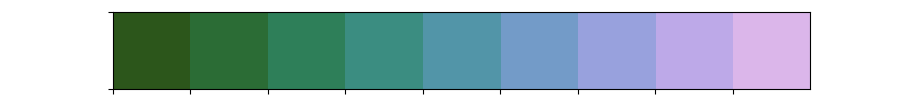

In [263]:
sns.choose_cubehelix_palette()